# Experiment Results Visualization

This notebook visualizes experiment results as 2D heatmaps showing:
- Minimum train error vs (gap_size, start_x)
- Minimum test error vs (gap_size, start_x)

The experiments test different training configurations where the model is trained on data outside the [start_x, end_x] range and tested within it.

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Load Real Experiment Data

This loads actual experiment results from ClearML tasks with the tag 'experiment-1.1.3'.

In [2]:
from clearml import Task

def load_real_data():
    """
    Load real experiment data from ClearML tasks with tag 'experiment-1.1.3'
    
    Returns:
        list: List of dictionaries with experiment results
    """
    # Get all tasks with the tag 'experiment-1.1.3'
    tasks = Task.get_tasks(
        project_name='mglyph-ml',
        tags=['experiment-1.1.3']
    )
    
    print(f"Found {len(tasks)} tasks with tag 'experiment-1.1.3'")
    
    data = []
    for task in tasks:
        # Get task parameters to extract start_x and end_x
        params = task.get_parameters()
        
        # Debug: print all parameter keys for the first task
        if len(data) == 0:
            print("\nAvailable parameter keys:")
            for key in sorted(params.keys()):
                print(f"  {key}: {params[key]}")
        
        # Try different possible parameter name formats
        start_x = None
        end_x = None
        
        # Try various possible parameter names
        for key in params.keys():
            if 'start' in key.lower() and 'x' in key.lower():
                start_x = float(params[key])
                print(f"Found start_x in key: {key}")
            if 'end' in key.lower() and 'x' in key.lower():
                end_x = float(params[key])
                print(f"Found end_x in key: {key}")
        
        # If not found, try to extract from task name
        if start_x is None or end_x is None:
            # Task name format: "EXP 1.1.3: s=<start>; e=<end>; i=20"
            name = task.name
            print(f"\nParsing task name: {name}")
            if 's=' in name and 'e=' in name:
                parts = name.split(';')
                for part in parts:
                    if 's=' in part:
                        start_x = float(part.split('s=')[1].strip())
                    if 'e=' in part:
                        end_x = float(part.split('e=')[1].strip())
        
        if start_x is None or end_x is None:
            print(f"Warning: Could not extract start_x/end_x from task '{task.name}'")
            continue
            
        gap_size = int(end_x - start_x)
        
        # Get the last scalar metrics to find minimum errors
        scalars = task.get_last_scalar_metrics()
        
        # Extract minimum train and test errors
        # Looking for 'Error (x units)' title with 'Train' and 'Test' series
        min_train_error = None
        min_test_error = None
        
        if 'Error (x units)' in scalars:
            if 'Train' in scalars['Error (x units)']:
                min_train_error = scalars['Error (x units)']['Train']['min']
            if 'Test' in scalars['Error (x units)']:
                min_test_error = scalars['Error (x units)']['Test']['min']
        
        # Only add if we have valid data
        if min_train_error is not None and min_test_error is not None:
            data.append({
                'gap_size': gap_size,
                'start_x': int(start_x),
                'end_x': int(end_x),
                'min_train_error': min_train_error,
                'min_test_error': min_test_error,
                'task_name': task.name
            })
            print(f"Added: start_x={start_x}, end_x={end_x}, gap={gap_size}")
        else:
            print(f"Warning: Task '{task.name}' missing error metrics")
    
    print(f"\nSuccessfully extracted data from {len(data)} tasks")
    return data

# Load the real data
data = load_real_data()
print(f"\nExample data point:")
if data:
    print(data[0])
else:
    print("No data found!")

Found 54 tasks with tag 'experiment-1.1.3'

Available parameter keys:
  Args/end_x: 10.0
  Args/max_augment_rotation_degrees: 5.0
  Args/max_augment_translation_percent: 0.05
  Args/max_iterations: 20
  Args/quick: False
  Args/seed: 420
  Args/start_x: 0.0
  Args/stop_x_error: 1.0
  Args/task_name: EXP 1.1.3: s=0.0; e=10.0; i=20
  Args/task_tag: experiment-1.1.3
  General/end_x: 10.0
  General/good_enough_x_error: 0.1
  General/max_augment_rotation_degrees: 5.0
  General/max_augment_translation_percent: 0.05
  General/max_iterations: 20
  General/quick: False
  General/seed: 420
  General/start_x: 0.0
  General/task_name: EXP 1.1.3: s=0.0; e=10.0; i=20
  General/task_tag: experiment-1.1.3
Found start_x in key: Args/start_x
Found end_x in key: Args/end_x
Found start_x in key: General/start_x
Found end_x in key: General/end_x
Added: start_x=0.0, end_x=10.0, gap=10
Found start_x in key: Args/start_x
Found end_x in key: Args/end_x
Found start_x in key: General/start_x
Found end_x in key: 

In [3]:
import pandas as pd

# Convert to DataFrame for easier inspection
df = pd.DataFrame(data)
print(f"Total tasks loaded: {len(df)}")
print("\nData summary:")
print(df[['start_x', 'end_x', 'gap_size', 'min_train_error', 'min_test_error']])
print("\nUnique gap sizes:", sorted(df['gap_size'].unique()))
print("Unique start_x values:", sorted(df['start_x'].unique()))

Total tasks loaded: 54

Data summary:
    start_x  end_x  gap_size  min_train_error  min_test_error
0         0     10        10         1.209679        8.473173
1        10     20        10         0.554590        1.095648
2        20     30        10         1.562299        2.658851
3        30     40        10         1.810883        2.738569
4        40     50        10         0.674299        0.674171
5        50     60        10         1.725881        2.812010
6        60     70        10         2.158729        2.500846
7        70     80        10         1.484245        1.041136
8        80     90        10         0.701489        0.685546
9        90    100        10         1.649624        1.014882
10        0     20        20         0.675454        8.659218
11       10     30        20         0.581978        2.229315
12       20     40        20         1.351503        4.020135
13       30     50        20         0.624721        0.903352
14       40     60        20    

## Inspect the Loaded Data

Let's examine what data was actually loaded to debug any issues.

## Helper Functions for Heatmap Creation

In [4]:
def create_heatmap_data(data, metric_key):
    """
    Convert list of results into a 2D array for heatmap.
    
    Args:
        data: List of dictionaries with experiment results
        metric_key: 'min_train_error' or 'min_test_error'
    
    Returns:
        tuple: (heatmap_array, gap_sizes, start_x_values)
    """
    # Get unique values
    gap_sizes = sorted(set(d['gap_size'] for d in data))
    start_x_values = sorted(set(d['start_x'] for d in data))
    
    # Create 2D array (rows=start_x, cols=gap_size)
    heatmap = np.full((len(start_x_values), len(gap_sizes)), np.nan)
    
    for d in data:
        row_idx = start_x_values.index(d['start_x'])
        col_idx = gap_sizes.index(d['gap_size'])
        heatmap[row_idx, col_idx] = d[metric_key]
    
    return heatmap, gap_sizes, start_x_values

## Visualize Results: Combined View

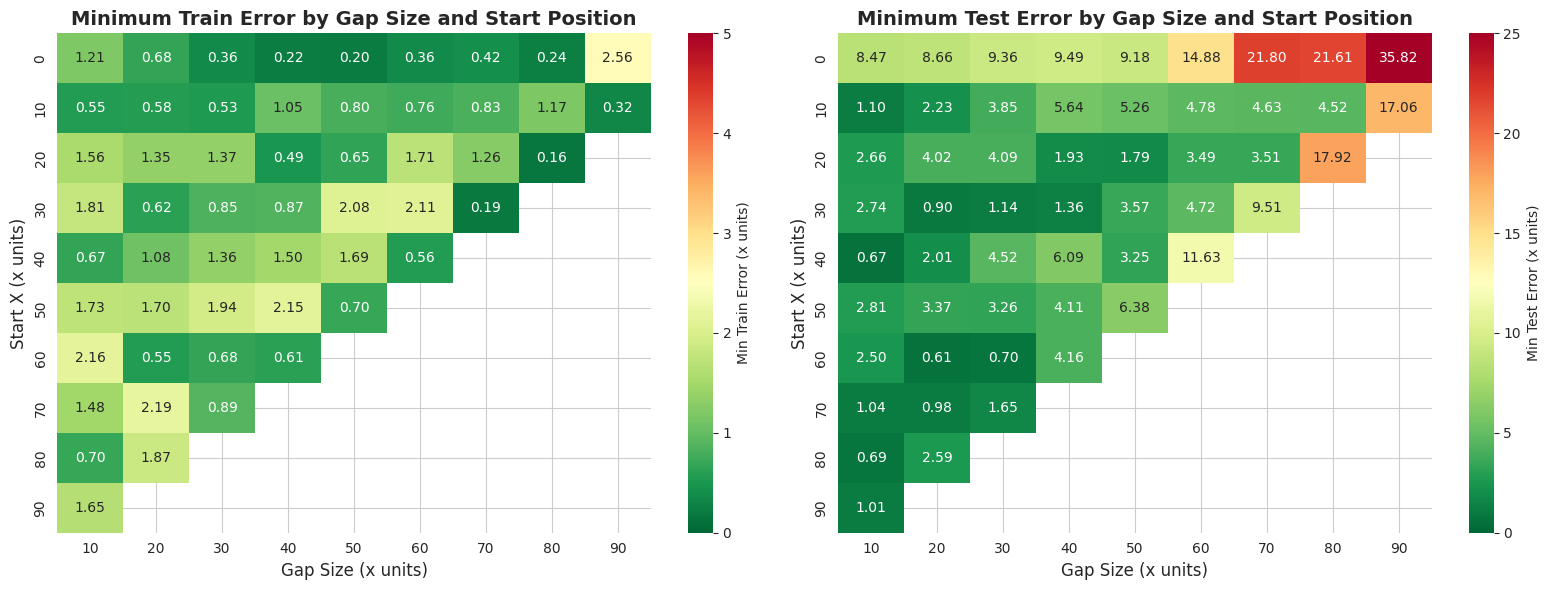

In [5]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train error heatmap
train_heatmap, gap_sizes, start_x_values = create_heatmap_data(data, 'min_train_error')
sns.heatmap(
    train_heatmap,
    ax=axes[0],
    xticklabels=gap_sizes,
    yticklabels=start_x_values,
    cmap='RdYlGn_r',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Min Train Error (x units)'},
    vmin=0,
    vmax=5
)
axes[0].set_xlabel('Gap Size (x units)', fontsize=12)
axes[0].set_ylabel('Start X (x units)', fontsize=12)
axes[0].set_title('Minimum Train Error by Gap Size and Start Position', fontsize=14, fontweight='bold')

# Test error heatmap
test_heatmap, gap_sizes, start_x_values = create_heatmap_data(data, 'min_test_error')
sns.heatmap(
    test_heatmap,
    ax=axes[1],
    xticklabels=gap_sizes,
    yticklabels=start_x_values,
    cmap='RdYlGn_r',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Min Test Error (x units)'},
    vmin=0,
    vmax=25
)
axes[1].set_xlabel('Gap Size (x units)', fontsize=12)
axes[1].set_ylabel('Start X (x units)', fontsize=12)
axes[1].set_title('Minimum Test Error by Gap Size and Start Position', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Visualize Results: Start X vs End X

This view shows how errors vary with the gap boundaries directly, with start_x on the horizontal axis and end_x on the vertical axis.

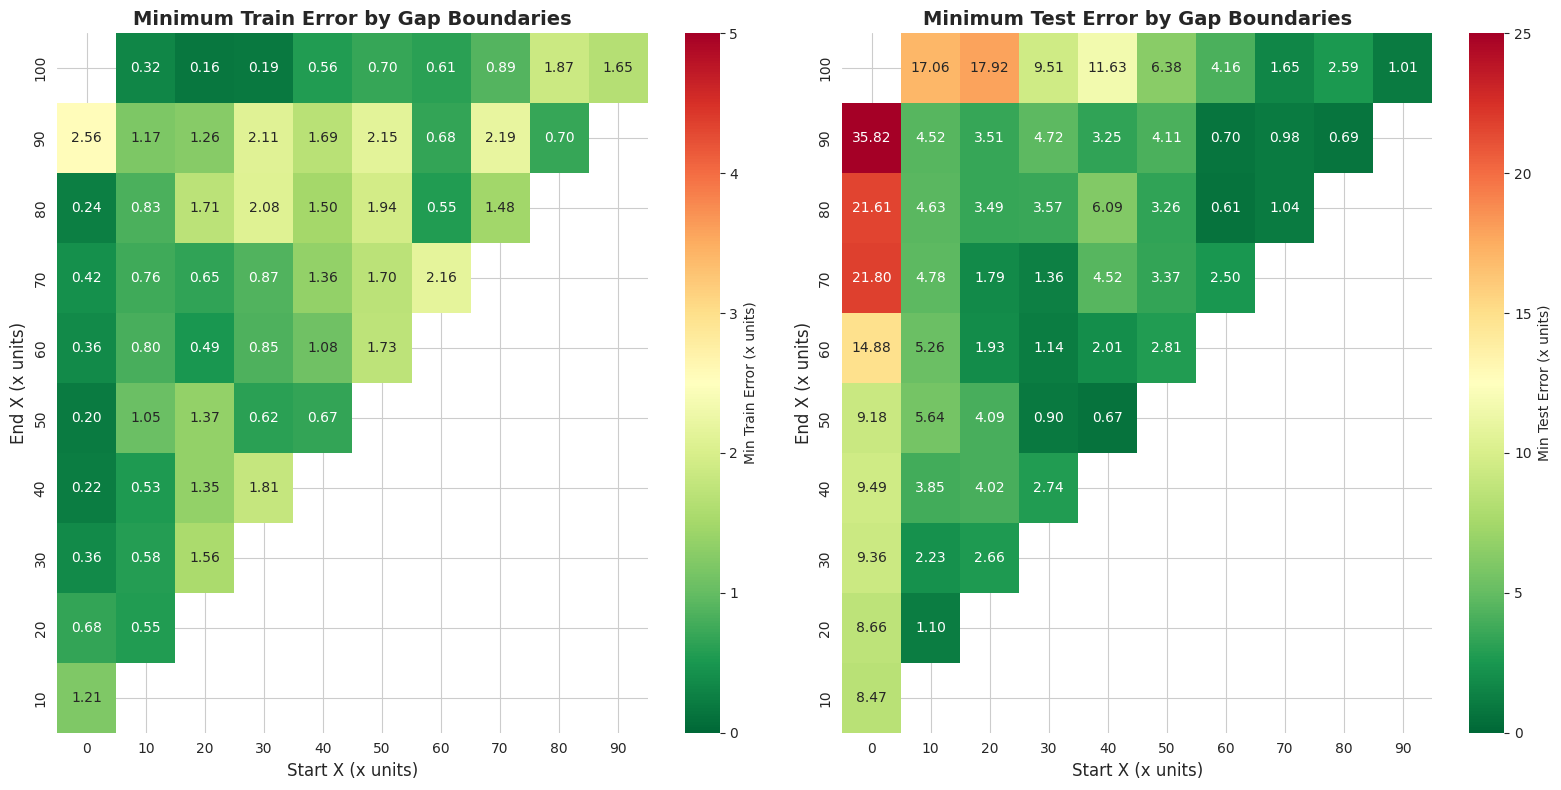

In [7]:
def create_startx_endx_heatmap(data, metric_key):
    """
    Convert list of results into a 2D array for heatmap with start_x and end_x as axes.
    
    Args:
        data: List of dictionaries with experiment results
        metric_key: 'min_train_error' or 'min_test_error'
    
    Returns:
        tuple: (heatmap_array, start_x_values, end_x_values)
    """
    # Get unique values
    start_x_values = sorted(set(d['start_x'] for d in data))
    end_x_values = sorted(set(d['end_x'] for d in data))
    
    # Create 2D array (rows=end_x, cols=start_x)
    heatmap = np.full((len(end_x_values), len(start_x_values)), np.nan)
    
    for d in data:
        row_idx = end_x_values.index(d['end_x'])
        col_idx = start_x_values.index(d['start_x'])
        heatmap[row_idx, col_idx] = d[metric_key]
    
    return heatmap, start_x_values, end_x_values

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Train error heatmap
train_heatmap_xy, start_x_vals, end_x_vals = create_startx_endx_heatmap(data, 'min_train_error')
sns.heatmap(
    train_heatmap_xy,
    ax=axes[0],
    xticklabels=start_x_vals,
    yticklabels=end_x_vals,
    cmap='RdYlGn_r',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Min Train Error (x units)'},
    vmin=0,
    vmax=5
)
axes[0].set_xlabel('Start X (x units)', fontsize=12)
axes[0].set_ylabel('End X (x units)', fontsize=12)
axes[0].set_title('Minimum Train Error by Gap Boundaries', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Test error heatmap
test_heatmap_xy, start_x_vals, end_x_vals = create_startx_endx_heatmap(data, 'min_test_error')
sns.heatmap(
    test_heatmap_xy,
    ax=axes[1],
    xticklabels=start_x_vals,
    yticklabels=end_x_vals,
    cmap='RdYlGn_r',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Min Test Error (x units)'},
    vmin=0,
    vmax=25
)
axes[1].set_xlabel('Start X (x units)', fontsize=12)
axes[1].set_ylabel('End X (x units)', fontsize=12)
axes[1].set_title('Minimum Test Error by Gap Boundaries', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()